In [48]:
import pandas as pd
import numpy as np
from ta.momentum import rsi
from ta.utils import dropna
import datetime
from api_helper import ShoonyaApiPy
import logging
import sched, time


In [2]:
#enable dbug to see request and responses
logging.basicConfig(level=logging.DEBUG)

#start of our program
api = ShoonyaApiPy()

In [3]:
def loginme():
    #credentials
    uid    = 'FA54439'
    pwd     = 'Gurdeep#7966'
    factor2 = '23031990'
    vc      = 'FA54439_U'
    apikey  = 'a4c5620bebfb7be65eb2821deab0eb62'
    imei    = 'GuruPC'

    #make the api call
    login = api.login(userid=uid, password=pwd, twoFA=factor2, vendor_code=vc, api_secret=apikey, imei=imei)
    if login['actid']=='FA54439':
        print('Login Success!!')
    else:
        print('Logout Failed!!')
    return True


In [4]:
def logoutme():
    logout = api.logout()
    if logout['stat']=='Ok':
        print('Logout Success!!')
    return True

In [5]:
def Supertrend(df, atr_period, multiplier):
    
    high = df['High']
    low = df['Low']
    close = df['Close']
    
    # calculate ATR
    price_diffs = [high - low, 
                   high - close.shift(), 
                   close.shift() - low]
    true_range = pd.concat(price_diffs, axis=1)
    true_range = true_range.abs().max(axis=1)
    # default ATR calculation in supertrend indicator
    atr = true_range.ewm(alpha=1/atr_period,min_periods=atr_period).mean() 
    # df['atr'] = df['tr'].rolling(atr_period).mean()
    
    # HL2 is simply the average of high and low prices
    hl2 = (high + low) / 2
    # upperband and lowerband calculation
    # notice that final bands are set to be equal to the respective bands
    final_upperband = upperband = hl2 + (multiplier * atr)
    final_lowerband = lowerband = hl2 - (multiplier * atr)
    
    # initialize Supertrend column to True
    supertrend = [True] * len(df)
    
    for i in range(1, len(df.index)):
        curr, prev = i, i-1
        
        # if current close price crosses above upperband
        if close[curr] > final_upperband[prev]:
            supertrend[curr] = True
        # if current close price crosses below lowerband
        elif close[curr] < final_lowerband[prev]:
            supertrend[curr] = False
        # else, the trend continues
        else:
            supertrend[curr] = supertrend[prev]
            
            # adjustment to the final bands
            if supertrend[curr] == True and final_lowerband[curr] < final_lowerband[prev]:
                final_lowerband[curr] = final_lowerband[prev]
            if supertrend[curr] == False and final_upperband[curr] > final_upperband[prev]:
                final_upperband[curr] = final_upperband[prev]

        # to remove bands according to the trend direction
        if supertrend[curr] == True:
            final_upperband[curr] = np.nan
        else:
            final_lowerband[curr] = np.nan
    
    return pd.DataFrame({
        'Supertrend': supertrend,
        'Final Lowerband': final_lowerband,
        'Final Upperband': final_upperband
    }, index=df.index)

In [6]:
def searchsymbol(exch,scr):   
    exch  = exch #NSE,NFO,MCX etc
    query = scr #'BANKNIFTY 30DEC CE' # multiple criteria to narrow results 
    # ret = api.searchscrip(exchange=exch, searchtext=query)
    mytoken=api.searchscrip(exchange=exch, searchtext=query)['values'][0]['token']
    return mytoken

In [14]:
def getdataop(token,time):    
    lastBusDay = datetime.datetime.today()-datetime.timedelta(days=5)
    lastBusDay = lastBusDay.replace(hour=0, minute=0, second=0, microsecond=0)
    ret = api.get_time_price_series(exchange='NFO', token=token, starttime=lastBusDay.timestamp(), interval=time)
    df=pd.DataFrame(ret)
    df=df.iloc[::-1]
    df['time']=pd.to_datetime(df['time'].astype(str), format='%d-%m-%Y %H:%M:%S')
    df.set_index('time',inplace=True)
    df=df.iloc[:,2:]
    df=df.astype(float)
    # return only last 300 bars
    df=df.iloc[-300:]
    return df

In [15]:
def getdataeq(token,time):    
    lastBusDay = datetime.datetime.today()-datetime.timedelta(days=5)
    lastBusDay = lastBusDay.replace(hour=0, minute=0, second=0, microsecond=0)
    ret = api.get_time_price_series(exchange='NSE', token=token, starttime=lastBusDay.timestamp(), interval=time)
    df=pd.DataFrame(ret)
    df=df.iloc[::-1]
    df['time']=pd.to_datetime(df['time'].astype(str), format='%d-%m-%Y %H:%M:%S')
    df.set_index('time',inplace=True)
    df=df.iloc[:,2:]
    df=df.astype(float)
    # return only last 300 bars
    df=df.iloc[-300:]
    return df

In [7]:
###Get ITM CE and PE Strikes
def get_ITM_strike(df):
    spot=df.intc.iloc[-1:][0]
    atm=50 * round(int(spot)/50)
    itm_ce=atm-50
    itm_pe=atm+50
    return spot,itm_ce,itm_pe

In [17]:
####Get ITM CE Token
def get_option_token_ce(expiry,strike):
    cscr=f'NIFTY{expiry}22C{strike}'
    tokence=searchsymbol(exch='NFO',scr=cscr)
    return cscr,tokence

In [18]:
####Get ITM PE Token
def get_option_token_pe(expiry, strike):
    pscr=f'NIFTY{expiry}22P{strike}'
    tokenpe=searchsymbol(exch='NFO',scr=pscr)
    return pscr,tokenpe

In [55]:
def resampler(df,time):
    newdf=pd.DataFrame()
    newdf['Open']=df.into.resample(time).first()
    newdf['Close']=df.intc.resample(time).last()
    newdf['High']=df.inth.resample(time).max()
    newdf['Low']=df.intl.resample(time).min()
    newdf['Vwap']=df.intvwap.resample(time).last()
    newdf['Volume']=df.intv.resample(time).sum()
    newdf['OI']=df.intoi.resample(time).sum()
    # newdf.dropna(axis=0,inplace=True)
    return newdf

In [11]:
def predf(data):
    
    ###Base Time Frame########
    datadf=data.copy()
    
    datadf=resampler(datadf,'5min')
    supertrendBTF=Supertrend(datadf,10,1)
    supertrendBTF['rsi']=rsi(datadf.Close,window=8,fillna=True)
    supertrendBTF['rsima']=supertrendBTF['rsi'].rolling(13).mean()
    supertrendBTF.reset_index(inplace=True)

    ###High Time Frame#########
    datadf=data.copy()
    
    datadf=resampler(datadf,'15min')
    supertrendHTF=Supertrend(datadf,10,0.8)
    supertrendHTF['rsi']=rsi(datadf.Close,window=8,fillna=True)
    supertrendHTF['rsima']=supertrendHTF['rsi'].rolling(13).mean()
    supertrendHTF.reset_index(inplace=True)
    
    #######Merge Base and HTF indicators###
    st=pd.merge(supertrendBTF,supertrendHTF,on='time',how='left')
    st=st.replace(to_replace=np.nan,method='ffill')
    st=st.set_index('time')
    
    #########Join everything in single df#######
    datadf=data.copy()
    
    datadf=resampler(datadf,'5min')
    datadf=datadf.join(st)
    
    
    return datadf

In [50]:
loginme()

Login Success!!


True

In [42]:
import time
ce_buy_script=''
pe_buy_script=''

sec=True
while sec==True:
    print(float(str(datetime.datetime.now().time()).split(':')[2]))
    starttime = time.time()
    time.sleep(1.0 - ((time.time() - starttime) % 60.0))
    if float(str(datetime.datetime.now().time()).split(':')[2])>58.0:
        sec=False

while True:
    starttime = time.time()
    time.sleep(62.0 - ((time.time() - starttime) % 60.0))
    now=datetime.datetime.now().time()
    if now >= datetime.time(9,20):
        ## Get nifty token and Data to calculate ITM CE and PE Strikes
        mytoken=searchsymbol('NSE','Nifty 50')
        nifty=getdataeq(mytoken,1)
        spot,itm_ce,itm_pe=get_ITM_strike(nifty)
        print(f' Spot: {spot}, ITM Call: {itm_ce}, ITM PUT: {itm_pe}')

        if not ce_buy_script:
            ##Get ITM CE token and download the data
            cscr,tokence=get_option_token_ce('17MAR',itm_ce)
        if not pe_buy_script:
            ##Get ITM PE token and download the data
            pscr,tokenpe=get_option_token_pe('17MAR',itm_pe)


        cedf=getdataop(token=tokence,time=1)
        pedf=getdataop(token=tokenpe,time=1)

        ##Preparing the Data before triggring actual Buy Sell Conditions 
        cedf=predf(cedf)
        pedf=predf(pedf)
    print(f'Call {cedf.Close.tail(1)},Put {pedf.Close.tail(1)}')

0.440191
1.45506
2.461566
3.4688
4.47902
5.483413
6.487575
7.488725
8.492274
9.501071
10.505561
11.50995
12.514586
13.516192
14.518594
15.526716
16.53418
17.541125
18.544224
19.55154
20.556439
21.561297
22.564576
23.578236
24.586759
25.591356
26.594595
27.598461
28.598847
29.603943
30.607338
31.614103
32.624389
33.631234
34.644261
35.650818
36.654163
37.658563
38.667019
39.674251
40.676809
41.68703
42.690024
43.694141
44.697925
45.709694
46.716978
47.726767
48.735026
49.743241
50.755504
51.755886
52.760153
53.763154
54.769163
55.774152
56.779388
57.785149
 Spot: 16875.5, ITM Call: 16850, ITM PUT: 16950
Call time
2022-03-14 15:25:00    219.1
Freq: 5T, Name: Close, dtype: float64,Put time
2022-03-14 15:25:00    234.0
Freq: 5T, Name: Close, dtype: float64
 Spot: 16881.6, ITM Call: 16850, ITM PUT: 16950
Call time
2022-03-14 15:25:00    219.55
Freq: 5T, Name: Close, dtype: float64,Put time
2022-03-14 15:25:00    234.6
Freq: 5T, Name: Close, dtype: float64
 Spot: 16884.5, ITM Call: 16850, IT

KeyboardInterrupt: 

<AxesSubplot:xlabel='time'>

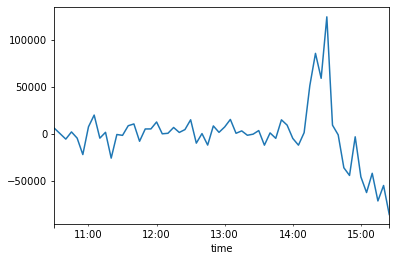

In [47]:
cedf.OI.plot()

In [51]:
mytoken=searchsymbol('NSE','Nifty 50')
nifty=getdataeq(mytoken,1)
spot,itm_ce,itm_pe=get_ITM_strike(nifty)
print(f' Spot: {spot}, ITM Call: {itm_ce}, ITM PUT: {itm_pe}')

 Spot: 16884.6, ITM Call: 16850, ITM PUT: 16950


In [52]:
cscr,tokence=get_option_token_ce('17MAR',itm_ce)

In [53]:
cedf=getdataop(token=tokence,time=1)

In [64]:
cedf[:-2]

,into,inth,intl,intc,intvwap,intv,intoi,v,oi
time,,,,,,,,,
2022-03-14 10:30:00,118.40,120.55,117.15,120.30,118.67,20800.0,0.0,2865850.0,470900.0
2022-03-14 10:31:00,121.00,122.80,120.05,120.50,121.52,19400.0,0.0,2885250.0,470900.0
2022-03-14 10:32:00,120.85,121.50,119.00,120.10,120.05,12750.0,5700.0,2898000.0,476600.0
2022-03-14 10:33:00,120.60,121.20,118.65,120.45,120.05,18450.0,0.0,2916450.0,476600.0
2022-03-14 10:34:00,120.50,122.05,120.00,120.55,120.05,13600.0,0.0,2930050.0,476600.0
...,...,...,...,...,...,...,...,...,...
2022-03-14 15:23:00,214.35,214.85,213.40,213.95,209.31,27250.0,0.0,17113200.0,518800.0
2022-03-14 15:24:00,213.75,213.90,211.20,211.20,213.24,53700.0,-43550.0,17166900.0,475250.0
2022-03-14 15:25:00,211.40,215.00,211.40,215.00,213.50,62000.0,0.0,17228900.0,475250.0


In [65]:
datadf=cedf[:-2].copy()
    
datadf=resampler(datadf,'5min')

In [66]:
datadf

,Open,Close,High,Low,Vwap,Volume,OI
time,,,,,,,
2022-03-14 10:30:00,118.40,120.55,122.80,117.15,120.05,85000.0,5700.0
2022-03-14 10:35:00,120.40,127.00,127.90,117.75,125.77,118300.0,0.0
2022-03-14 10:40:00,127.30,125.90,127.95,124.25,126.24,89500.0,-5750.0
2022-03-14 10:45:00,126.15,126.15,126.20,121.90,126.12,69500.0,1900.0
2022-03-14 10:50:00,126.50,124.40,126.75,118.55,123.97,113600.0,-4700.0
...,...,...,...,...,...,...,...
2022-03-14 15:05:00,217.55,220.25,222.65,211.95,217.95,344500.0,-62650.0
2022-03-14 15:10:00,219.60,215.40,220.85,214.00,215.47,304150.0,-42150.0
2022-03-14 15:15:00,215.00,213.25,215.60,207.85,215.13,306200.0,-71600.0


In [71]:
str(datadf.index[-1])

'2022-03-14 15:25:00'